# Importing the Libraries


In [46]:
# numpy is needed for dealing with large arrays
import numpy as np
# PIL Library is used to deal with images
from PIL import Image
# Handling External Requests
import requests
# Keras models
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras import backend
# Optimizing 
from scipy.optimize import fmin_l_bfgs_b
# Involves in I/O to convert to bytes
from io import BytesIO



# Setting Hyperparameters

In [47]:
# Hyperparams
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 224
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
CONTENT_WEIGHT = 100
STYLE_WEIGHT = 5000
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

# Loading Images

In [48]:
input_image_path = "https://cdn.mos.cms.futurecdn.net/SSsejZ9krDiV9N8TExmRGZ-1200-80.jpg"
style_image_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR4835l1WsqLT3HannAC5L_dd6SVk1B1GQ7tA&usqp=CAU"

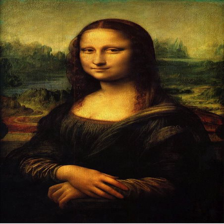

In [49]:
# Input image
input_image = Image.open(BytesIO(requests.get(input_image_path).content))
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save('input.png')
input_image

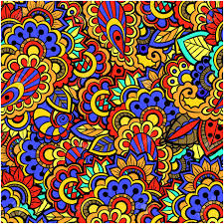

In [50]:
# Style Image
style_image = Image.open(BytesIO(requests.get(style_image_path).content))
style_image = style_image.resize((224,224))
style_image.save('output.png')
style_image

# Image-Preprocessing

In [51]:
# Need to convert the images from 3D to 4 Dimensions
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
print(input_image_array)
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array = style_image_array[:, :, :, ::-1]


[[[[ 57.  61.  36.]
   [ 68.  76.  46.]
   [ 76.  88.  50.]
   ...
   [ 39.  77.  36.]
   [ 49.  82.  39.]
   [ 50.  83.  39.]]

  [[ 53.  67.  36.]
   [ 62.  78.  43.]
   [ 70.  86.  46.]
   ...
   [ 68.  97.  52.]
   [ 64.  91.  44.]
   [ 69.  96.  49.]]

  [[ 54.  76.  40.]
   [ 63.  83.  44.]
   [ 69.  86.  42.]
   ...
   [ 85. 102.  53.]
   [ 80.  96.  48.]
   [ 80.  96.  47.]]

  ...

  [[  7.   7.   9.]
   [  9.   9.  11.]
   [  9.   9.  11.]
   ...
   [  5.   3.   4.]
   [  5.   5.   5.]
   [  8.   8.   8.]]

  [[  5.   5.   7.]
   [  7.   7.   9.]
   [  6.   6.   8.]
   ...
   [  2.   1.   1.]
   [  1.   1.   1.]
   [  6.   6.   6.]]

  [[165. 165. 167.]
   [167. 167. 169.]
   [166. 166. 168.]
   ...
   [165. 165. 165.]
   [165. 165. 165.]
   [167. 167. 167.]]]]


In [52]:
# Convert numpy arrays to tensors

input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))
print(combination_image)


Tensor("Placeholder:0", shape=(1, 224, 224, 3), dtype=float32)


In [53]:
# Making a iinput Tensor by concatenating the input images

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
print(input_tensor)

Tensor("concat:0", shape=(3, 224, 224, 3), dtype=float32)


# Modeling

In [54]:
# Passing Input Tensors to VGG16 Model 
model = VGG16(input_tensor=input_tensor, include_top=False)

In [55]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(3, 224, 224, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 224, 224, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 224, 224, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 112, 112, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 112, 112, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 112, 112, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 56, 56, 128)          0     

# Computing Losses

## Getting Data from Model Layers

In [56]:
# Loading the layer output from VGG16 Model
layers = dict([(layer.name, layer.output) for layer in model.layers])


In [57]:
# Extracting the layers of CONTENT from the above layers mostly from the front layers in the architecture because according to the paper 
# It is mentioned that front layers contain content of the image
layer_features = layers["block2_conv2"]

In [58]:
layer_features.shape

TensorShape([3, 112, 112, 128])

In [59]:
# Splitting layer data into content and output image
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]



## Content Loss

In [60]:
# We need to define a function i.e content loss which is computing the loss between output image and content image
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))


In [61]:
# Initializing total loss to zero
loss = 0
# Calculating the content loss and adding the loss to the total loss
loss =loss+CONTENT_WEIGHT * content_loss(content_image_features,combination_features)

## Style Loss

Generally gram matrix is a matrix with dimension equal to no of channels * no of channels which has a dot product with it's transpose which forms a gram matrix

In [62]:
# Computing the gram matrix 
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [63]:
# Style Loss function generally computes the loss between 2 gram matrices of the layers output for the style and combination images 
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

In [64]:
# Computing Loss over 5 different layers to find the style loss

style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    # adding the style loss at each layer to total loss
    loss=loss+(STYLE_WEIGHT / len(style_layers)) * style_loss

## Variation Loss

It was observed that optimization to reduce only the style and content losses led to highly pixelated and noisy outputs. To cover the same, total variation loss was introduced. The total variation loss is analogous to regularization loss. This is introduced for ensuring spatial continuity and smoothness in the generated image to avoid noisy and overly pixelated results. The same is defined in the function as follows:



In [65]:
# Adding the variation Loss makes the image noise free and smooth

def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [66]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

In [67]:
# Adding the loss with gradients with respect to combination_image
outputs = [loss]
outputs=outputs+backend.gradients(loss, combination_image)

# Using Optimization fmin_l_bfgs_b 

In [68]:
# Obtaining the loss and gradients  
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients


In [69]:
# This function is used to make optimizer function work because here we use fmin_l_bfgs_b which optimizes the argument ehich is in the function 
class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

# Training the Image

Iteration 0 completed with loss 449174558474240
Iteration 1 completed with loss 315211777048576
Iteration 2 completed with loss 270939321270272
Iteration 3 completed with loss 247892711309312
Iteration 4 completed with loss 235085940916224
Iteration 5 completed with loss 226662050430976
Iteration 6 completed with loss 220886611263488
Iteration 7 completed with loss 216558878064640
Iteration 8 completed with loss 212730283819008
Iteration 9 completed with loss 210214204735488
Iteration 10 completed with loss 208083917733888
Iteration 11 completed with loss 206352072835072
Iteration 12 completed with loss 205137553391616
Iteration 13 completed with loss 203973097160704
Iteration 14 completed with loss 202858804805632
Iteration 15 completed with loss 201992496480256
Iteration 16 completed with loss 201281746501632
Iteration 17 completed with loss 200646410108928
Iteration 18 completed with loss 200085648441344
Iteration 19 completed with loss 199547737341952


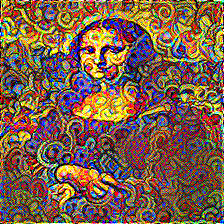

In [70]:
# Initialising a random image
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS+10):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration i completed loss is ",loss)
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save("output.png")
output_image

# Output image

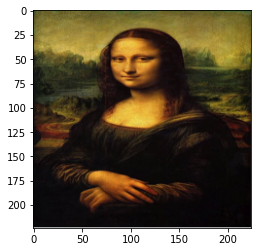

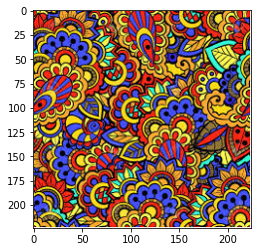

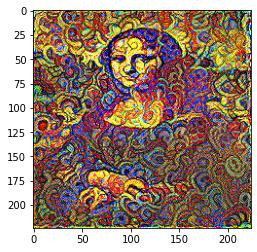

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('input.png'))
plt.show()
plt.imshow(plt.imread('style.png'))
plt.show()
plt.imshow(plt.imread('output.png'))
plt.show()